# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "CF"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'CF',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups                            
Sample_134  Q96GW7                                       20.864
Sample_208  A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3   15.071
Sample_036  A0A0A0MTP9;F8VZI9;Q9BWQ8                     16.116
Sample_050  P27169                                       19.872
Sample_026  M0R1Q1                                       20.664
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by CF: runs/alzheimer_study/preds/pred_real_na_CF.csv


Sample ID   protein groups          
Sample_062  Q9NS00;Q9NS00-2            11.368
Sample_018  O94898                     14.869
Sample_181  Q96MU8;Q96MU8-2;Q96MU8-3   11.938
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 13.043
            A0A075B6Q5                 13.535
            A0A075B6R2                 13.819
            A0A075B6S5                 13.443
            A0A087WSY4                 13.413
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   12.836
            Q9UI40;Q9UI40-2            12.993
            Q9UIW2                     13.550
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   12.101
            Q9UP79                     12.237
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,13.832,15.050,16.842,19.863,16.035,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.755,19.067,...,15.528,15.576,14.397,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.699,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,14.837,17.705,17.039,15.029,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.531,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,15.250,15.345,17.084,18.708,14.249,19.433,11.910,10.742
Sample_207,15.739,16.877,15.469,16.898,14.551,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6K4,...,O14793,O95479;R4GMU1,P01282;P01282-2,P10619;P10619-2;X6R5C5;X6R8A1,P21810,Q14956;Q14956-2,Q6ZMP0;Q6ZMP0-2,Q9HBW1,Q9NY15,P17050
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,16.148,...,13.008,13.117,11.922,11.966,12.994,12.113,13.439,13.507,12.863,13.695
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,11.881,19.067,16.127,...,12.331,13.202,12.453,12.868,13.861,11.649,13.460,13.068,13.999,11.144
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,15.387,...,12.364,12.542,13.176,13.063,12.828,13.658,12.619,13.496,11.585,12.399
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,16.565,...,11.830,12.574,12.112,12.901,12.498,12.621,12.645,13.257,12.160,12.664
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,16.418,...,11.848,11.329,13.363,13.159,11.710,12.616,13.554,13.897,13.836,11.551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.621,16.413,19.102,15.350,...,14.269,14.064,16.826,18.182,15.225,15.044,14.192,16.605,14.995,14.257
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,16.582,...,14.273,17.700,16.802,20.202,15.280,15.086,13.978,18.086,15.557,14.171
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,15.768,...,14.473,16.882,16.917,20.105,15.690,15.135,13.138,17.066,15.706,15.690


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 166.65it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.40it/s]

100%|██████████| 3/3 [00:00<00:00,  3.74it/s]

100%|██████████| 3/3 [00:00<00:00,  3.97it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  6.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.92it/s]

100%|██████████| 4/4 [00:00<00:00,  4.31it/s]

100%|██████████| 4/4 [00:00<00:00,  4.67it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.94it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.42it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.93it/s]

100%|██████████| 5/5 [00:01<00:00,  2.68it/s]

100%|██████████| 5/5 [00:01<00:00,  3.01it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  8.25it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.93it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  3.89it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  3.39it/s]

100%|██████████| 6/6 [00:01<00:00,  2.99it/s]

100%|██████████| 6/6 [00:01<00:00,  3.60it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.28it/s]

 43%|████▎     | 3/7 [00:00<00:00,  4.40it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.07it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  3.64it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  3.64it/s]

100%|██████████| 7/7 [00:01<00:00,  3.69it/s]

100%|██████████| 7/7 [00:01<00:00,  3.92it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  6.34it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.44it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.54it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.12it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.70it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.47it/s]

100%|██████████| 8/8 [00:02<00:00,  2.32it/s]

100%|██████████| 8/8 [00:02<00:00,  2.82it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.99it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.56it/s]

 44%|████▍     | 4/9 [00:01<00:01,  3.06it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  3.15it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  3.14it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  3.18it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  3.13it/s]

100%|██████████| 9/9 [00:02<00:00,  3.14it/s]

100%|██████████| 9/9 [00:02<00:00,  3.24it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:00,  8.29it/s]

 30%|███       | 3/10 [00:00<00:01,  6.23it/s]

 40%|████      | 4/10 [00:00<00:01,  5.37it/s]

 50%|█████     | 5/10 [00:00<00:01,  4.90it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.45it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.46it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.38it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.24it/s]

100%|██████████| 10/10 [00:02<00:00,  3.66it/s]

100%|██████████| 10/10 [00:02<00:00,  4.42it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.89it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.84it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.28it/s]

 45%|████▌     | 5/11 [00:01<00:01,  4.25it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  4.37it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  4.42it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.70it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.69it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.31it/s]

100%|██████████| 11/11 [00:02<00:00,  4.06it/s]

100%|██████████| 11/11 [00:02<00:00,  4.41it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.68it/s]

 25%|██▌       | 3/12 [00:00<00:01,  5.17it/s]

 33%|███▎      | 4/12 [00:00<00:01,  4.73it/s]

 42%|████▏     | 5/12 [00:01<00:01,  4.40it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.34it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.20it/s]

 67%|██████▋   | 8/12 [00:01<00:01,  3.71it/s]

 75%|███████▌  | 9/12 [00:02<00:00,  3.67it/s]

 83%|████████▎ | 10/12 [00:02<00:00,  3.81it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  3.85it/s]

100%|██████████| 12/12 [00:02<00:00,  3.71it/s]

100%|██████████| 12/12 [00:02<00:00,  4.05it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.94it/s]

 23%|██▎       | 3/13 [00:00<00:01,  5.41it/s]

 31%|███       | 4/13 [00:00<00:01,  4.71it/s]

 38%|███▊      | 5/13 [00:01<00:01,  4.03it/s]

 46%|████▌     | 6/13 [00:01<00:01,  3.80it/s]

 54%|█████▍    | 7/13 [00:01<00:01,  3.76it/s]

 62%|██████▏   | 8/13 [00:01<00:01,  3.96it/s]

 69%|██████▉   | 9/13 [00:02<00:00,  4.08it/s]

 77%|███████▋  | 10/13 [00:02<00:00,  4.04it/s]

 85%|████████▍ | 11/13 [00:02<00:00,  3.85it/s]

 92%|█████████▏| 12/13 [00:02<00:00,  3.95it/s]

100%|██████████| 13/13 [00:03<00:00,  4.01it/s]

100%|██████████| 13/13 [00:03<00:00,  4.14it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01,  7.85it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.97it/s]

 29%|██▊       | 4/14 [00:00<00:02,  3.92it/s]

 36%|███▌      | 5/14 [00:01<00:02,  3.76it/s]

 43%|████▎     | 6/14 [00:01<00:02,  3.83it/s]

 50%|█████     | 7/14 [00:01<00:01,  4.01it/s]

 57%|█████▋    | 8/14 [00:01<00:01,  4.19it/s]

 64%|██████▍   | 9/14 [00:02<00:01,  4.19it/s]

 71%|███████▏  | 10/14 [00:02<00:00,  4.24it/s]

 79%|███████▊  | 11/14 [00:02<00:00,  4.17it/s]

 86%|████████▌ | 12/14 [00:02<00:00,  4.16it/s]

 93%|█████████▎| 13/14 [00:03<00:00,  4.15it/s]

100%|██████████| 14/14 [00:03<00:00,  3.72it/s]

100%|██████████| 14/14 [00:03<00:00,  4.10it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:01,  6.98it/s]

 20%|██        | 3/15 [00:00<00:02,  5.18it/s]

 27%|██▋       | 4/15 [00:00<00:02,  5.42it/s]

 33%|███▎      | 5/15 [00:00<00:01,  5.13it/s]

 40%|████      | 6/15 [00:01<00:02,  4.43it/s]

 47%|████▋     | 7/15 [00:01<00:01,  4.49it/s]

 53%|█████▎    | 8/15 [00:01<00:01,  4.58it/s]

 60%|██████    | 9/15 [00:01<00:01,  4.59it/s]

 67%|██████▋   | 10/15 [00:02<00:00,  5.00it/s]

 73%|███████▎  | 11/15 [00:02<00:00,  5.08it/s]

 80%|████████  | 12/15 [00:02<00:00,  5.24it/s]

 87%|████████▋ | 13/15 [00:02<00:00,  5.29it/s]

 93%|█████████▎| 14/15 [00:02<00:00,  4.37it/s]

100%|██████████| 15/15 [00:03<00:00,  4.41it/s]

100%|██████████| 15/15 [00:03<00:00,  4.81it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.002      0.050 0.018          0.857 0.237       0.167   
2             0.005 0.002      0.049 0.019          0.763 0.094       0.719   
3             0.006 0.003      0.067 0.025          0.755 0.096       0.718   
4             0.005 0.002      0.051 0.019          0.767 0.098       0.724   
5             0.005 0.003      0.052 0.021          0.763 0.101       0.717   
6             0.005 0.002      0.058 0.021          0.790 0.093       0.814   
7             0.005 0.002      0.052 0.019          0.785 0.094       0.807   
8             0.005 0.002      0.049 0.018          0.794 0.094       0.795   
9             0.005 0.002      0.048 0.016          0.792 0.097       0.795   
10            0.004 0.001      0.036 0.007          0.794 0.096       0.796   
11            0.004 0.001      0.041 0.010          0.824 0.081       0.837   
12            0.004 0.001      0.042 0.011          0.825 0.081       0.831   
13            0.004 0.002      0.042 0.016          0.810 0.083       0.815   
14            0.004 0.002      0.040 0.005          0.807 0.084       0.815   
15            0.004 0.002      0.042 0.013          0.802 0.082       0.811   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.099   0.268 0.136                  0.575 0.047        0.864   
2          0.108   0.734 0.075                  0.775 0.060        0.860   
3          0.110   0.730 0.077                  0.771 0.062        0.856   
4          0.102   0.738 0.069                  0.777 0.055        0.856   
5          0.098   0.734 0.075                  0.774 0.061        0.857   
6          0.091   0.796 0.065                  0.825 0.054        0.902   
7          0.099   0.790 0.069                  0.819 0.059        0.900   
8          0.097   0.789 0.067                  0.819 0.057        0.901   
9          0.099   0.788 0.072                  0.818 0.061        0.903   
10         0.098   0.789 0.070                  0.819 0.059        0.900   
11         0.085   0.827 0.061                  0.851 0.053        0.916   
12         0.088   0.824 0.064                  0.849 0.054        0.914   
13         0.091   0.808 0.064                  0.836 0.055        0.913   
14         0.092   0.807 0.065                  0.834 0.056        0.911   
15         0.094   0.802 0.066                  0.830 0.057        0.910   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.058                  0.833 0.086        210.000 0.000  
2          0.056                  0.811 0.082        210.000 0.000  
3          0.056                  0.805 0.084        210.000 0.000  
4          0.055                  0.808 0.084        210.000 0.000  
5          0.053                  0.815 0.077        210.000 0.000  
6          0.042                  0.879 0.060        210.000 0.000  
7          0.043                  0.877 0.059        210.000 0.000  
8          0.043                  0.875 0.059        210.000 0.000  
9          0.043                  0.880 0.057        210.000 0.000  
10         0.044                  0.878 0.060        210.000 0.000  
11         0.044                  0.901 0.054        210.000 0.000  
12         0.045                  0.899 0.056        210.000 0.000  
13         0.045                  0.897 0.055        210.000 0.000  
14         0.046                  0.895 0.056        210.000 0.000  
15         0.045                  0.893 0.055 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 465.36it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  6.50it/s]

100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.29it/s]

100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

100%|██████████| 3/3 [00:00<00:00,  3.57it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  7.64it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  4.74it/s]

100%|██████████| 4/4 [00:00<00:00,  3.52it/s]

100%|██████████| 4/4 [00:00<00:00,  4.03it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  5.72it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.97it/s]

 80%|████████  | 4/5 [00:00<00:00,  3.76it/s]

100%|██████████| 5/5 [00:01<00:00,  3.69it/s]

100%|██████████| 5/5 [00:01<00:00,  3.90it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  7.91it/s]

 50%|█████     | 3/6 [00:00<00:00,  5.62it/s]

 67%|██████▋   | 4/6 [00:00<00:00,  5.11it/s]

 83%|████████▎ | 5/6 [00:00<00:00,  4.95it/s]

100%|██████████| 6/6 [00:01<00:00,  4.65it/s]

100%|██████████| 6/6 [00:01<00:00,  5.07it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  6.93it/s]

 43%|████▎     | 3/7 [00:00<00:00,  5.11it/s]

 57%|█████▋    | 4/7 [00:00<00:00,  4.18it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  4.16it/s]

 86%|████████▌ | 6/7 [00:01<00:00,  4.46it/s]

100%|██████████| 7/7 [00:01<00:00,  4.65it/s]

100%|██████████| 7/7 [00:01<00:00,  4.66it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:00,  7.72it/s]

 38%|███▊      | 3/8 [00:00<00:00,  5.47it/s]

 50%|█████     | 4/8 [00:00<00:00,  4.84it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  4.42it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  4.27it/s]

 88%|████████▊ | 7/8 [00:01<00:00,  4.51it/s]

100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

100%|██████████| 8/8 [00:01<00:00,  4.70it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  6.99it/s]

 33%|███▎      | 3/9 [00:00<00:01,  5.64it/s]

 44%|████▍     | 4/9 [00:00<00:01,  4.75it/s]

 56%|█████▌    | 5/9 [00:01<00:00,  4.49it/s]

 67%|██████▋   | 6/9 [00:01<00:00,  4.16it/s]

 78%|███████▊  | 7/9 [00:01<00:00,  4.15it/s]

 89%|████████▉ | 8/9 [00:01<00:00,  4.17it/s]

100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

100%|██████████| 9/9 [00:02<00:00,  4.30it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  7.99it/s]

 30%|███       | 3/10 [00:00<00:01,  6.16it/s]

 40%|████      | 4/10 [00:00<00:01,  5.44it/s]

 50%|█████     | 5/10 [00:00<00:00,  5.02it/s]

 60%|██████    | 6/10 [00:01<00:00,  4.65it/s]

 70%|███████   | 7/10 [00:01<00:00,  4.38it/s]

 80%|████████  | 8/10 [00:01<00:00,  4.30it/s]

 90%|█████████ | 9/10 [00:01<00:00,  4.11it/s]

100%|██████████| 10/10 [00:02<00:00,  4.22it/s]

100%|██████████| 10/10 [00:02<00:00,  4.65it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 11.00it/s]

 36%|███▋      | 4/11 [00:00<00:01,  6.26it/s]

 45%|████▌     | 5/11 [00:00<00:01,  5.79it/s]

 55%|█████▍    | 6/11 [00:00<00:00,  5.62it/s]

 64%|██████▎   | 7/11 [00:01<00:00,  5.36it/s]

 73%|███████▎  | 8/11 [00:01<00:00,  4.56it/s]

 82%|████████▏ | 9/11 [00:01<00:00,  4.44it/s]

 91%|█████████ | 10/11 [00:02<00:00,  4.04it/s]

100%|██████████| 11/11 [00:02<00:00,  4.18it/s]

100%|██████████| 11/11 [00:02<00:00,  4.88it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  9.61it/s]

 25%|██▌       | 3/12 [00:00<00:01,  6.82it/s]

 33%|███▎      | 4/12 [00:00<00:01,  5.56it/s]

 42%|████▏     | 5/12 [00:00<00:01,  4.99it/s]

 50%|█████     | 6/12 [00:01<00:01,  4.57it/s]

 58%|█████▊    | 7/12 [00:01<00:01,  4.54it/s]

 67%|██████▋   | 8/12 [00:01<00:00,  4.66it/s]

 75%|███████▌  | 9/12 [00:01<00:00,  4.71it/s]

 83%|████████▎ | 10/12 [00:01<00:00,  4.86it/s]

 92%|█████████▏| 11/12 [00:02<00:00,  4.74it/s]

100%|██████████| 12/12 [00:02<00:00,  4.64it/s]

100%|██████████| 12/12 [00:02<00:00,  4.96it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 12.86it/s]

 31%|███       | 4/13 [00:00<00:01,  8.79it/s]

 38%|███▊      | 5/13 [00:00<00:00,  8.28it/s]

 46%|████▌     | 6/13 [00:00<00:00,  8.15it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  8.06it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  8.00it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  7.74it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  7.40it/s]

 85%|████████▍ | 11/13 [00:01<00:00,  6.93it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  6.74it/s]

100%|██████████| 13/13 [00:01<00:00,  6.72it/s]

100%|██████████| 13/13 [00:01<00:00,  7.58it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:01, 11.80it/s]

 29%|██▊       | 4/14 [00:00<00:01,  7.85it/s]

 36%|███▌      | 5/14 [00:00<00:01,  7.15it/s]

 43%|████▎     | 6/14 [00:00<00:01,  6.69it/s]

 50%|█████     | 7/14 [00:00<00:01,  6.71it/s]

 57%|█████▋    | 8/14 [00:01<00:00,  6.74it/s]

 64%|██████▍   | 9/14 [00:01<00:00,  7.00it/s]

 71%|███████▏  | 10/14 [00:01<00:00,  7.23it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  7.39it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  7.49it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  7.57it/s]

100%|██████████| 14/14 [00:01<00:00,  7.61it/s]

100%|██████████| 14/14 [00:01<00:00,  7.39it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.69it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.75it/s]

 40%|████      | 6/15 [00:00<00:01,  8.79it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.54it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.33it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.19it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.08it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.00it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.94it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.88it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.84it/s]

100%|██████████| 15/15 [00:01<00:00,  7.82it/s]

100%|██████████| 15/15 [00:01<00:00,  8.35it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.043 0.013          0.164 0.344       0.019   
2             0.004 0.001      0.037 0.010          0.692 0.154       0.473   
3             0.005 0.003      0.048 0.018          0.701 0.105       0.573   
4             0.006 0.004      0.063 0.030          0.680 0.108       0.573   
5             0.005 0.002      0.057 0.020          0.739 0.081       0.693   
6             0.003 0.001      0.027 0.006          0.733 0.086       0.682   
7             0.003 0.001      0.030 0.005          0.786 0.103       0.779   
8             0.003 0.001      0.025 0.006          0.796 0.101       0.782   
9             0.004 0.001      0.035 0.004          0.824 0.101       0.789   
10            0.004 0.001      0.035 0.004          0.823 0.100       0.781   
11            0.004 0.001      0.036 0.004          0.819 0.099       0.780   
12            0.004 0.001      0.033 0.007          0.813 0.091       0.781   
13            0.002 0.000      0.021 0.001          0.829 0.091       0.792   
14            0.002 0.000      0.021 0.000          0.824 0.095       0.785   
15            0.002 0.000      0.021 0.000          0.834 0.089       0.803   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.047   0.032 0.076                  0.505 0.021        0.866   
2          0.110   0.553 0.107                  0.654 0.075        0.684   
3          0.132   0.620 0.096                  0.693 0.066        0.752   
4          0.128   0.613 0.097                  0.685 0.071        0.746   
5          0.105   0.710 0.074                  0.756 0.057        0.826   
6          0.109   0.701 0.076                  0.749 0.058        0.822   
7          0.097   0.777 0.078                  0.809 0.066        0.902   
8          0.096   0.784 0.076                  0.815 0.064        0.903   
9          0.093   0.800 0.068                  0.829 0.056        0.920   
10         0.101   0.795 0.073                  0.826 0.060        0.917   
11         0.099   0.793 0.073                  0.824 0.059        0.916   
12         0.098   0.791 0.069                  0.822 0.056        0.915   
13         0.099   0.804 0.070                  0.834 0.056        0.918   
14         0.098   0.799 0.070                  0.829 0.057        0.921   
15         0.106   0.812 0.072                  0.841 0.060        0.924   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.061                  0.831 0.087        210.000 0.000  
2          0.089                  0.677 0.099        210.000 0.000  
3          0.076                  0.681 0.095        210.000 0.000  
4          0.076                  0.676 0.093        210.000 0.000  
5          0.060                  0.791 0.078        210.000 0.000  
6          0.061                  0.790 0.080        210.000 0.000  
7          0.048                  0.882 0.060        210.000 0.000  
8          0.048                  0.883 0.060        210.000 0.000  
9          0.041                  0.898 0.055        210.000 0.000  
10         0.043                  0.896 0.055        210.000 0.000  
11         0.044                  0.895 0.056        210.000 0.000  
12         0.044                  0.895 0.056        210.000 0.000  
13         0.043                  0.900 0.054        210.000 0.000  
14         0.042                  0.899 0.052        210.000 0.000  
15         0.042                  0.904 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1613.81it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 67.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 50.53it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 44.29it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:00<00:00, 42.69it/s]

100%|██████████| 5/5 [00:00<00:00, 42.46it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 83%|████████▎ | 5/6 [00:00<00:00, 42.86it/s]

100%|██████████| 6/6 [00:00<00:00, 40.77it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 42.24it/s]

100%|██████████| 7/7 [00:00<00:00, 38.64it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 39.91it/s]

100%|██████████| 8/8 [00:00<00:00, 37.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 42.43it/s]

100%|██████████| 9/9 [00:00<00:00, 37.76it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 50%|█████     | 5/10 [00:00<00:00, 41.83it/s]

100%|██████████| 10/10 [00:00<00:00, 35.70it/s]

100%|██████████| 10/10 [00:00<00:00, 36.41it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [00:00<00:00, 39.56it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 35.84it/s]

100%|██████████| 11/11 [00:00<00:00, 35.86it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 42%|████▏     | 5/12 [00:00<00:00, 42.51it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 37.24it/s]

100%|██████████| 12/12 [00:00<00:00, 37.33it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 38%|███▊      | 5/13 [00:00<00:00, 43.56it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 38.14it/s]

100%|██████████| 13/13 [00:00<00:00, 37.73it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 36%|███▌      | 5/14 [00:00<00:00, 39.94it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 36.78it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 35.69it/s]

100%|██████████| 14/14 [00:00<00:00, 36.09it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███▎      | 5/15 [00:00<00:00, 41.86it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 36.81it/s]

 93%|█████████▎| 14/15 [00:00<00:00, 35.55it/s]

100%|██████████| 15/15 [00:00<00:00, 36.16it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.002 0.000      0.021 0.000          0.000 0.000       0.000   
2             0.002 0.000      0.020 0.000          0.626 0.090       0.556   
3             0.002 0.000      0.020 0.000          0.663 0.104       0.585   
4             0.002 0.000      0.020 0.000          0.683 0.101       0.593   
5             0.002 0.000      0.021 0.000          0.685 0.100       0.598   
6             0.002 0.000      0.021 0.001          0.720 0.087       0.649   
7             0.002 0.000      0.020 0.000          0.723 0.085       0.651   
8             0.002 0.000      0.021 0.001          0.709 0.087       0.672   
9             0.002 0.000      0.021 0.000          0.699 0.088       0.656   
10            0.002 0.000      0.021 0.000          0.701 0.089       0.653   
11            0.002 0.000      0.021 0.001          0.699 0.090       0.650   
12            0.002 0.000      0.021 0.000          0.693 0.091       0.645   
13            0.002 0.000      0.020 0.000          0.680 0.088       0.636   
14            0.002 0.000      0.021 0.000          0.677 0.090       0.629   
15            0.002 0.000      0.020 0.000          0.670 0.087       0.622   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.731   
2          0.123   0.583 0.095                  0.657 0.065        0.747   
3          0.115   0.615 0.086                  0.681 0.064        0.766   
4          0.114   0.629 0.090                  0.694 0.066        0.778   
5          0.121   0.632 0.095                  0.697 0.068        0.773   
6          0.123   0.676 0.088                  0.731 0.064        0.817   
7          0.119   0.679 0.084                  0.733 0.062        0.818   
8          0.114   0.685 0.086                  0.735 0.068        0.821   
9          0.107   0.673 0.083                  0.724 0.066        0.818   
10         0.105   0.672 0.083                  0.724 0.065        0.818   
11         0.098   0.670 0.080                  0.722 0.065        0.814   
12         0.122   0.664 0.095                  0.718 0.074        0.813   
13         0.110   0.652 0.085                  0.708 0.066        0.812   
14         0.109   0.647 0.084                  0.704 0.064        0.809   
15         0.113   0.640 0.085                  0.698 0.063        0.806   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.678 0.073        210.000 0.000  
2          0.068                  0.677 0.079        210.000 0.000  
3          0.063                  0.711 0.078        210.000 0.000  
4          0.063                  0.718 0.080        210.000 0.000  
5          0.064                  0.710 0.081        210.000 0.000  
6          0.059                  0.763 0.074        210.000 0.000  
7          0.057                  0.753 0.074        210.000 0.000  
8          0.061                  0.769 0.077        210.000 0.000  
9          0.062                  0.761 0.076        210.000 0.000  
10         0.062                  0.759 0.077        210.000 0.000  
11         0.062                  0.755 0.075        210.000 0.000  
12         0.062                  0.755 0.077        210.000 0.000  
13         0.058                  0.755 0.071        210.000 0.000  
14         0.059                  0.754 0.073        210.000 0.000  
15         0.059                  0.752 0.072 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,3,4,15
score_time,3,4,9
test_precision,1,15,7
test_recall,11,15,8
test_f1,11,15,8
test_balanced_accuracy,11,15,8
test_roc_auc,11,15,8
test_average_precision,11,15,8
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 15.66it/s]

 27%|██▋       | 4/15 [00:00<00:01,  9.89it/s]

 40%|████      | 6/15 [00:00<00:01,  8.84it/s]

 47%|████▋     | 7/15 [00:00<00:00,  8.56it/s]

 53%|█████▎    | 8/15 [00:00<00:00,  8.37it/s]

 60%|██████    | 9/15 [00:01<00:00,  8.21it/s]

 67%|██████▋   | 10/15 [00:01<00:00,  8.12it/s]

 73%|███████▎  | 11/15 [00:01<00:00,  8.05it/s]

 80%|████████  | 12/15 [00:01<00:00,  7.99it/s]

 87%|████████▋ | 13/15 [00:01<00:00,  7.93it/s]

 93%|█████████▎| 14/15 [00:01<00:00,  7.92it/s]

100%|██████████| 15/15 [00:01<00:00,  7.88it/s]

100%|██████████| 15/15 [00:01<00:00,  8.40it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 42.27it/s]

100%|██████████| 8/8 [00:00<00:00, 38.25it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:00, 17.60it/s]

 36%|███▋      | 4/11 [00:00<00:00, 11.16it/s]

 55%|█████▍    | 6/11 [00:00<00:00, 10.20it/s]

 73%|███████▎  | 8/11 [00:00<00:00,  9.63it/s]

 91%|█████████ | 10/11 [00:01<00:00,  9.35it/s]

100%|██████████| 11/11 [00:01<00:00,  9.25it/s]

100%|██████████| 11/11 [00:01<00:00,  9.83it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf


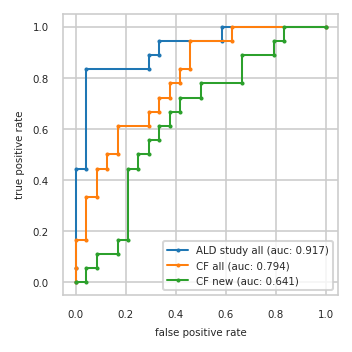

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       CF all       CF new      
             fpr   tpr    fpr   tpr    fpr   tpr
0          0.000 0.000  0.000 0.000  0.000 0.000
1          0.000 0.056  0.000 0.056  0.042 0.000
2          0.000 0.444  0.000 0.167  0.042 0.056
3          0.042 0.444  0.042 0.167  0.083 0.056
4          0.042 0.833  0.042 0.333  0.083 0.111
5          0.292 0.833  0.083 0.333  0.167 0.111
6          0.292 0.889  0.083 0.444  0.167 0.167
7          0.333 0.889  0.125 0.444  0.208 0.167
8          0.333 0.944  0.125 0.500  0.208 0.444
9          0.583 0.944  0.167 0.500  0.250 0.444
10         0.583 1.000  0.167 0.611  0.250 0.500
11         1.000 1.000  0.292 0.611  0.292 0.500
12           NaN   NaN  0.292 0.667  0.292 0.556
13           NaN   NaN  0.333 0.667  0.333 0.556
14           NaN   NaN  0.333 0.722  0.333 0.611
15           NaN   NaN  0.375 0.722  0.375 0.611
16           NaN   NaN  0.375 0.778  0.375 0.667
17           NaN   NaN  0.417 0.778  0.417 0.667
18           NaN   NaN  0.417 0.833  0.417 0.722
19           NaN   NaN  0.458 0.833  0.500 0.722
20           NaN   NaN  0.458 0.944  0.500 0.778
21           NaN   NaN  0.625 0.944  0.667 0.778
22           NaN   NaN  0.625 1.000  0.667 0.889
23           NaN   NaN  1.000 1.000  0.792 0.889
24           NaN   NaN    NaN   NaN  0.792 0.944
25           NaN   NaN    NaN   NaN  0.833 0.944
26           NaN   NaN    NaN   NaN  0.833 1.000
27           NaN   NaN    NaN   NaN  1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,CF all,CF new
rank,,,
0,P10636-2;P10636-6,P10636-2;P10636-6,Q14894
1,Q9P2E7;Q9P2E7-2,P02766,Q9NQS3;Q9NQS3-2;Q9NQS3-3
2,P09960;P09960-4,F8WAD8;Q9P0K1;Q9P0K1-2;Q9P0K1-3;Q9P0K1-4;Q9P0K1-5,O43854;O43854-2
3,P61981,P08670,Q9NUQ9
4,P02741,P04075,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P04075,Q9Y2T3;Q9Y2T3-3,Q96GD0
6,P14174,P61981,E9PK25;G3V1A4;P23528
7,P08294,P25189;P25189-2,P31321
8,P05413;S4R371,Q14894,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf


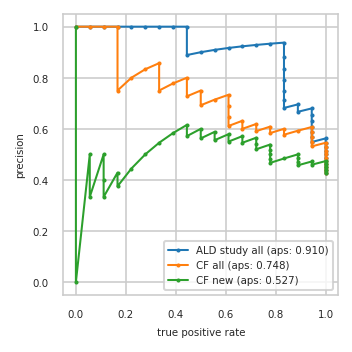

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all          CF all          CF new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.459 0.944
6          0.500 1.000     0.500 1.000     0.472 0.944
7          0.514 1.000     0.514 1.000     0.457 0.889
8          0.529 1.000     0.529 1.000     0.471 0.889
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.531 0.944     0.500 0.889
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.567 0.944     0.467 0.778
13         0.586 0.944     0.586 0.944     0.483 0.778
14         0.607 0.944     0.607 0.944     0.500 0.778
15         0.630 0.944     0.593 0.889     0.519 0.778
16         0.654 0.944     0.577 0.833     0.538 0.778
17         0.680 0.944     0.600 0.833     0.520 0.722
18         0.667 0.889     0.583 0.778     0.542 0.722
19         0.696 0.889     0.609 0.778     0.565 0.722
20         0.682 0.833     0.591 0.722     0.545 0.667
21         0.714 0.833     0.619 0.722     0.571 0.667
22         0.750 0.833     0.600 0.667     0.550 0.611
23         0.789 0.833     0.632 0.667     0.579 0.611
24         0.833 0.833     0.611 0.611     0.556 0.556
25         0.882 0.833     0.647 0.611     0.588 0.556
26         0.938 0.833     0.688 0.611     0.562 0.500
27         0.933 0.778     0.733 0.611     0.600 0.500
28         0.929 0.722     0.714 0.556     0.571 0.444
29         0.923 0.667     0.692 0.500     0.615 0.444
30         0.917 0.611     0.750 0.500     0.583 0.389
31         0.909 0.556     0.727 0.444     0.545 0.333
32         0.900 0.500     0.800 0.444     0.500 0.278
33         0.889 0.444     0.778 0.389     0.444 0.222
34         1.000 0.444     0.750 0.333     0.375 0.167
35         1.000 0.389     0.857 0.333     0.429 0.167
36         1.000 0.333     0.833 0.278     0.333 0.111
37         1.000 0.278     0.800 0.222     0.400 0.111
38         1.000 0.222     0.750 0.167     0.500 0.111
39         1.000 0.167     1.000 0.167     0.333 0.056
40         1.000 0.111     1.000 0.111     0.500 0.056
41         1.000 0.056     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf


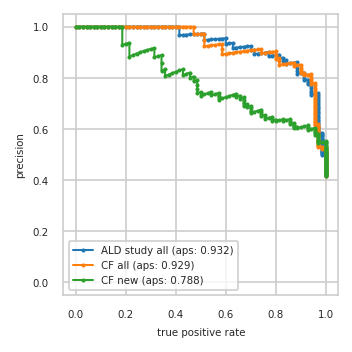

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf


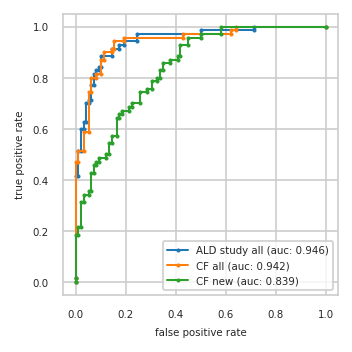

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_CF all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF all.pkl'),
 'results_CF new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_CF new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_CF/auc_roc_curve_train.pdf')}